In [485]:
import numpy as np
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [593]:
def barr_method(Q, p, A, b, v0, eps, mu = None):
    v_seq = [v0]
    if mu is None:
        mu = 20
    t = 1
    while len(b)/t > eps:
        v = centering_step(Q, p, A, b, t, v_seq[-1], eps)[-1]
        v_seq.append(v)
        t = t*mu

    return v_seq

def centering_step(Q, p, A, b, t, v0, eps):
    max_it = 1000
    v_seq = [v0]
    for it in range(max_it):
        v = v_seq[-1]
        v_last = v.copy()
        grad_f = calc_grad(Q, p, A, b, t, v)
        hess_f = calc_hess(Q, p, A, b, t, v)
        hess_f_inv = np.linalg.inv(hess_f)

        # Line search
        u = 0.1
        incv = - hess_f_inv @ grad_f
        beta = 0.8
        while True:
            if np.all(b-v@A > 0) and eval_obj(Q, p, A, b, t, v+u*incv) <= eval_obj(Q, p, A, b, t, v) + 0.1*u*grad_f@incv:
                break
            u = beta*u
            # print(u)
        v = v + u*incv
        v_seq.append(v)
        if np.linalg.norm(v-v_last) < eps:
            break
    return v_seq

def eval_obj(Q, p, A, b, t, v):
    if t == -1:
        return v @ Q @ v + p @ v
    return v @ Q @ v + p @ v - (1/t)*np.sum(np.log(b-v@A))

def calc_grad(Q, p, A, b, t, v):
    G = np.zeros((A.shape[0]))
    for i in range(A.shape[1]):
        G += A[:,i]*(1/(b[i]-A[:,i]@v))
    return 2 * Q @ v + p + (1/t)*G

def calc_hess(Q, p, A, b, t, v):
    H = np.zeros((Q.shape))
    for i in range(A.shape[0]):
        H += np.outer(A[:,i], A[:,i])*(1/(b[i]-A[:,i]@v)**2)
    return 2*Q - (1/t)*H

def plot_gap(Q, p, A, b, v_seq, mu):
    opt = eval_obj(Q, p, A, b, -1, v_seq[-1])
    obj_list = []
    for i in range(len(v_seq)-1):
        obj_list.append(eval_obj(Q, p, A, b, -1, v_seq[i])-opt)
    criteria = [len(b)/mu**j for j in range(len(v_seq)-1)]
    plt.semilogy(obj_list, label = "Gap to optimal")
    plt.semilogy(criteria, label = "Criteria (duality gap)")
    plt.legend()
    plt.show()

def plot_dif_mu(Q, p, A, b, v0, mu_list):
    n_mu = len(mu_list)
    cmap = plt.get_cmap('gnuplot')
    for i in range(n_mu):
        v_seq = barr_method(Q, p, A, b, v0, 1e-10, mu = mu_list[i])
        opt = eval_obj(Q, p, A, b, -1, v_seq[-1])
        obj_list = []
        for k in range(len(v_seq)-1):
            obj_list.append(eval_obj(Q, p, A, b, -1, v_seq[k])-opt)
        c= cmap(i/n_mu)
        criteria = [len(b)/mu_list[i]**j for j in range(len(v_seq)-1)]
        plt.semilogy(obj_list, color = c, label = "Gap (Mu = " + str(mu_list[i]) + ")")
        plt.semilogy(criteria, color = c, linestyle="dashed", label = "Criteria (Mu = " + str(mu_list[i]) + ")")
    plt.legend()
    plt.show()

def Simulate(n, d, seed = None):
    if seed is not None:
        np.random.seed(seed)

    lambda_ = 10
    y = np.random.rand(d)
    X = 10*np.random.rand(n,d)

    Q = 1/2*np.eye(d)
    p = y
    b = lambda_*np.ones(2*n)
    v0 = np.ones(d)/10
    A = np.concatenate([X, X]).T
    return Q, p, A, b, v0

def grad_val(reps):
    gradNorm_list = []
    for r in range(reps):
        Q, p, A, b, v0 = Simulate(10, 5, r)
        eps = 1e-10
        v = barr_method(Q, p, A, b, v0, eps)[-1]
        gradNorm = np.linalg.norm(calc_grad(Q, p, A, b, np.inf, v))
        gradNorm_list.append(gradNorm)
    return np.mean(gradNorm), np.std(gradNorm)

In [594]:
grad_val(10)

/tmp/ipykernel_2843855/410666125.py:41: RuntimeWarning: invalid value encountered in log
  return v @ Q @ v + p @ v - (1/t)*np.sum(np.log(b-v@A))


(np.float64(2.3802476300956027e-08), np.float64(0.0))

In [585]:
seed = 41
np.random.seed(seed)

n = 20
d = 10

lambda_ = 10
y = np.random.rand(d)
X = 10*np.random.rand(n,d)

Q = 1/2*np.eye(d)
p = y
b = lambda_*np.ones(2*n)
v0 = np.ones(d)/10
eps = 1e-10
t = 100
A = np.concatenate([X, X]).T

/tmp/ipykernel_2843855/2893343175.py:41: RuntimeWarning: invalid value encountered in log
  return v @ Q @ v + p @ v - (1/t)*np.sum(np.log(b-v@A))


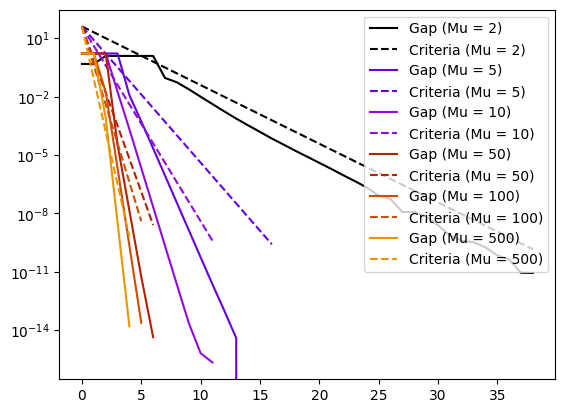

In [586]:
mu_list = [2, 5, 10, 50, 100, 500]
plot_dif_mu(Q, p, A, b, v0, mu_list)

In [563]:
v_seq = barr_method(Q, p, A, b, v0, eps)

/tmp/ipykernel_2843855/2879002307.py:41: RuntimeWarning: invalid value encountered in log
  return v @ Q @ v + p @ v - (1/t)*np.sum(np.log(b-v@A))


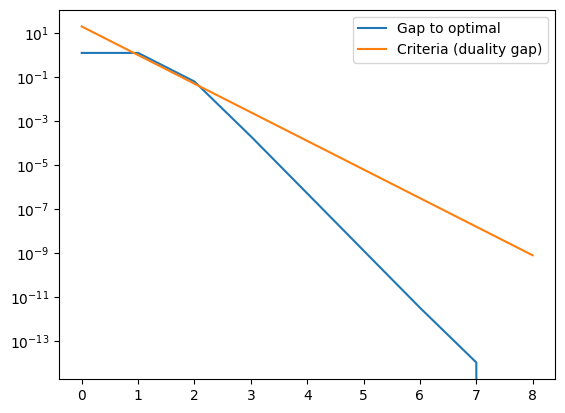

In [569]:
mu = 20
plot_gap(Q, p, A, b, v_seq, mu)

/tmp/ipykernel_2843855/2701183445.py:41: RuntimeWarning: invalid value encountered in log
  return v @ Q @ v + p @ v - (1/t)*np.sum(np.log(b-v@A))


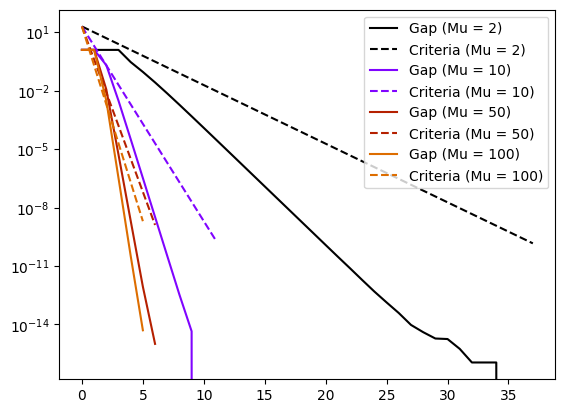

In [574]:
plot_dif_mu(Q, p, A, b, v0, [2, 10, 50, 100])

In [445]:
v_seq

[array([1., 1., 1., 1.]),
 array([-0.72299475, -1.28995193, -1.02413881, -1.06226652]),
 array([-0.37821095, -0.95432419, -0.73508164, -0.60357422]),
 array([-0.37457685, -0.95075044, -0.73202484, -0.59870768]),
 array([-0.37454049, -0.95071467, -0.73199425, -0.59865898]),
 array([-0.37454013, -0.95071432, -0.73199395, -0.5986585 ]),
 array([-0.37454012, -0.95071431, -0.73199395, -0.59865849])]

In [554]:
for i in range(len(v_seq)):
    print(eval_obj(Q, p, A, b, 1e5, v_seq[i]))

0.28516813761797655
0.28516813761797655
-0.9071826148794631
-0.9695806779714552
-0.9697803343743504
-0.9697807674138335
-0.9697807647966966
-0.9697807646058103
-0.9697807645966683
-0.9697807645966683


In [575]:
print()np.linalg.norm(calc_grad(Q, p, A, b, np.inf, v_seq[-1]))

3.443037868288744e-08


In [439]:
v_seq[-1]

array([-0.37821095, -0.95432418, -0.73508164, -0.60357422])